## Importing Data and Libraries

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

import copy
import time

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
adult_uci = fetch_ucirepo(id=2)

dataset = adult_uci.data.original
dataset['labels'] = dataset.income

for i in range(len(dataset.labels)):
  if (dataset.labels[i] == '<=50K.'):
    dataset.labels[i] = '<=50K'
  elif (dataset.labels[i] == '>50K.'):
    dataset.labels[i] = '>50K'

dataset = dataset.drop(columns=['income'])

print(dataset.labels[4881-1])
print(dataset.info())

<ipython-input-3-7dc5b1c285a9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.labels[i] = '<=50K'
<ipython-input-3-7dc5b1c285a9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.labels[i] = '>50K'


>50K
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  labels          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


## Pre-processing Data: Cleaning, Equalizing, and LabelEncoding

In [ ]:
missing = dataset.isnull().sum()
duplicates = dataset.duplicated().sum()

dataset = dataset.dropna()
dataset = dataset.drop_duplicates()

print("Missing values removed:\n" + str(missing))
print("\nDuplicates removed:", duplicates)
print(dataset.info())

Missing values removed:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
labels              0
dtype: int64

Duplicates removed: 48
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47573 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             47573 non-null  int64 
 1   workclass       47573 non-null  object
 2   fnlwgt          47573 non-null  int64 
 3   education       47573 non-null  object
 4   education-num   47573 non-null  int64 
 5   marital-status  47573 non-null  object
 6   occupation      47573 non-null  object
 7   relationship    47573 non-null  object
 8   race            47573 non-null  object
 9   sex        

In [ ]:
labelCount = 0
data = dataset
numerical = dataset.select_dtypes(include=['int64']).columns
categoricalColumns = dataset.select_dtypes(include=['object']).columns
categoricalColumns = [column for column in categoricalColumns if column != 'labels']
for column in categoricalColumns:
    labelCount += len(dataset[f'{column}'].unique())
    one_hot_encoded = pd.get_dummies(dataset[column], prefix=f'{column}_')
    data = pd.concat([data, one_hot_encoded], axis=1)

data = data.drop(columns=categoricalColumns)
data['labels'] = dataset['labels']

print(data.info(), labelCount, len(categoricalColumns), len(numerical))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47573 entries, 0 to 48841
Columns: 109 entries, age to native-country__Yugoslavia
dtypes: int64(6), object(1), uint8(102)
memory usage: 7.5+ MB
None 102 8 6


In [ ]:
classCount = data['labels'].value_counts()
minClassCount = classCount.min()
print(classCount)
newData = pd.DataFrame(columns=data.columns)

for label in classCount.index:
      classSamples = data[data['labels'] == label]
      newSamples = classSamples.sample(minClassCount)
      newData = pd.concat([newData, newSamples])

data = newData
print(data.info())

<=50K    36038
>50K     11535
Name: labels, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23070 entries, 44665 to 1162
Columns: 109 entries, age to native-country__Yugoslavia
dtypes: object(109)
memory usage: 19.4+ MB
None


In [ ]:
featuresRaw = data.drop('labels', axis=1)
labelsRaw = data.labels

labelMapping = {}

labelEncoder = LabelEncoder()
labelsEncoded = labelEncoder.fit_transform(labelsRaw)

for class_ in labelEncoder.classes_:
  encoding = labelEncoder.transform([class_])[0]
  labelMapping[encoding] = class_

labels = labelsEncoded
print(labelMapping)

{0: '<=50K', 1: '>50K'}


## Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(featuresRaw, labels, test_size=0.3, random_state=42)

trainScaler = StandardScaler()
X_train = trainScaler.fit_transform(X_train)
X_test = trainScaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns=featuresRaw.columns)
X_test_df = pd.DataFrame(X_test, columns=featuresRaw.columns)

X_train_df.head()

X_data = np.array(featuresRaw)
y_data = np.array(labels)

## Model Construction and Training

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features, l2=0.0):
    super(LogisticRegression, self).__init__()
    self.layer1 = nn.Linear(num_features, 1)
    self.sig = nn.Sigmoid()
    self.l2 = l2


  def forward(self, x):
    out0 = self.layer1(x)
    out1 = self.sig(out0)
    return out1

In [ ]:
def resetWeights(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()

def trainModelKFold(model, epochs, lossFn, X, y, lr=0.01, batchSize=32, decisionThreshold=0.5, k=1):
    trainAcc, testAcc = np.zeros(epochs), np.zeros(epochs)
    trainErr, testErr = np.zeros(epochs), np.zeros(epochs)
    trainLoss, testLoss = np.zeros(epochs), np.zeros(epochs)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        trainScaler = StandardScaler()
        X_train = trainScaler.fit_transform(X_train)
        X_test = trainScaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train).float()
        X_test_tensor = torch.tensor(X_test).float()
        y_train_tensor = torch.tensor(y_train).float()
        y_test_tensor = torch.tensor(y_test).float()

        resetWeights(model)
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
        for epoch in range(epochs):
            for batch_X, batch_y in train_loader:
              output = model(batch_X)
              loss = lossFn(output.squeeze(), batch_y)
              loss.backward()

              with torch.no_grad():
                  for param in model.parameters():
                      param.data -= lr * param.grad

                  model.zero_grad()

            with torch.no_grad():
                trainLoss[epoch] += loss.item()
                trainPredictions = (np.array(output.flatten()) > 0.5).astype(int)
                trainError = np.mean(trainPredictions != np.array(batch_y).astype(int))

                output = model(X_test_tensor)
                loss = lossFn(output.squeeze(), y_test_tensor)

                testLoss[epoch] += loss.item()
                testPredictions = (np.array(output.flatten()) > decisionThreshold).astype(int)
                testError = np.mean(testPredictions != np.array(y_test_tensor).astype(int))

                trainErr[epoch] += trainError.item()
                testErr[epoch] += testError.item()
                trainAcc[epoch] += 1 - trainError.item()
                testAcc[epoch] += 1 - testError.item()

    avg_trainAcc = trainAcc/k
    avg_testAcc = testAcc/k
    avg_trainErr = trainErr/k
    avg_testErr = testErr/k
    avg_trainLoss = trainLoss/k
    avg_testLoss = testLoss/k

    return avg_trainAcc, avg_testAcc, avg_trainErr, avg_testErr, avg_trainLoss, avg_testLoss

def trainModel(model, epochs, lossFn, X_train, X_test, y_train, y_test, lr=0.01, batchSize=32, decisionThreshold=0.5):
    trainAcc, testAcc = np.zeros(epochs), np.zeros(epochs)
    trainErr, testErr = np.zeros(epochs), np.zeros(epochs)
    trainLoss, testLoss = np.zeros(epochs), np.zeros(epochs)
    batchCount = 0

    resetWeights(model)
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
          batchCount += 1
          output = model(batch_X)
          loss = lossFn(output.squeeze(), batch_y)
          loss.backward()

          with torch.no_grad():
              for param in model.parameters():
                  param.data -= lr * param.grad

              model.zero_grad()

          with torch.no_grad():
              trainLoss[epoch] += loss.item()
              trainPredictions = (np.array(output.flatten()) > decisionThreshold).astype(int)
              trainError = np.mean(trainPredictions != np.array(y_train).astype(int))

              output = model(X_test)
              loss = lossFn(output.squeeze(), y_test)

              testLoss[epoch] += loss.item()
              testPredictions = (np.array(output.flatten()) > decisionThreshold).astype(int)
              testError = np.mean(testPredictions != np.array(y_test).astype(int))

              trainErr[epoch] += trainError.item()
              testErr[epoch] += testError.item()
              trainAcc[epoch] += 1 - trainError.item()
              testAcc[epoch] += 1 - testError.item()


    trainAcc = trainAcc/(batchCount/epochs)
    testAcc = testAcc/(batchCount/epochs)
    trainErr = trainErr/(batchCount/epochs)
    testErr = testErr/(batchCount/epochs)
    trainLoss = trainLoss/(batchCount/epochs)
    testLoss = testLoss/(batchCount/epochs)

    return trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss


X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

## Grid Search Analysis

In [ ]:
epochs_list = [50, 100, 250]
learning_rates = [1, 0.5, 0.05]
batchSizes = [1024]
lambdas = [0, 0.001, 0.1]
trainedModels = []

num_features = len(X_train_df.columns)
lossFn = nn.BCELoss()

for lambda_ in lambdas:
  model = LogisticRegression(num_features, l2=lambda_)
  for batchSize in batchSizes:
    for lr in learning_rates:
        for epochs in epochs_list:
          startTime = time.time()
          trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModelKFold(
              model,
              epochs,
              lossFn,
              X_data,
              y_data,
              lr=lr,
              batchSize=batchSize,
              k=5,
          )
          trainingTime = time.time() - startTime
          trainedModels.append({ 'model': copy.deepcopy(model),
                                'hyperparameters': {'epochs': epochs, 'lr': lr, 'batchSize': batchSize, 'lambda': lambda_ },
                                'trainingStats': { 'testAcc': testAcc[-1], 'trainAcc': trainAcc[-1],
                                                    'testError': testErr[-1], 'trainError': trainErr[-1],
                                                    'testLoss': testLoss[-1], 'trainLoss': trainLoss[-1] },
                                'trainingTime': trainingTime
                                })
          print(f'Completed epochs, lr, batchSize, lambda, test error: {epochs}, {lr}, {batchSize}, {lambda_}, --- {testAcc[-1]}')

Completed epochs, lr, batchSize, lambda, test error: 50, 1, 1024, 0, --- 0.8031209362808843
Completed epochs, lr, batchSize, lambda, test error: 100, 1, 1024, 0, --- 0.8034243606415258
Completed epochs, lr, batchSize, lambda, test error: 250, 1, 1024, 0, --- 0.7955353272648461
Completed epochs, lr, batchSize, lambda, test error: 50, 0.5, 1024, 0, --- 0.8159947984395318
Completed epochs, lr, batchSize, lambda, test error: 100, 0.5, 1024, 0, --- 0.8155613350671868
Completed epochs, lr, batchSize, lambda, test error: 250, 0.5, 1024, 0, --- 0.8138708279150411
Completed epochs, lr, batchSize, lambda, test error: 50, 0.05, 1024, 0, --- 0.8162982228001734
Completed epochs, lr, batchSize, lambda, test error: 100, 0.05, 1024, 0, --- 0.816861725184222
Completed epochs, lr, batchSize, lambda, test error: 250, 0.05, 1024, 0, --- 0.8191157347204161
Completed epochs, lr, batchSize, lambda, test error: 50, 1, 1024, 0.001, --- 0.8043346337234503
Completed epochs, lr, batchSize, lambda, test error: 100

## Find best model that maximizies accuracy using ROC curve:

In [ ]:
def findOptimalThresholdForModelAcc(model, X_test_tensor, y_test_tensor):
  with torch.no_grad(): output = model(X_test_tensor)
  _, _, thresholds = roc_curve(y_test_tensor.detach().numpy(), output.detach().numpy().flatten(), pos_label=1)
  optimalAcc = None
  optimalThreshold = None

  for threshold in thresholds:
    testPredictions = (np.array(output.detach().numpy().flatten()) > threshold).astype(int)
    testAcc = 1 - np.mean(testPredictions != np.array(y_test_tensor).astype(int))

    if (optimalThreshold == None):
      optimalThreshold = threshold
      optimalAcc = testAcc
    elif (testAcc > optimalAcc):
      optimalThreshold = threshold
      optimalAcc = testAcc



  return optimalAcc, optimalThreshold

In [ ]:
globalOptimalModel = None
globalOptimalLoss = None
globalOptimalAcc = None
globalOptimalThreshold = None

for model_ in trainedModels:
    optimalAcc, optimalThreshold = findOptimalThresholdForModelAcc(
        model_['model'],
        X_test_tensor,
        y_test_tensor
    )
    optimalLoss = model_['trainingStats']['testLoss']

    if (globalOptimalLoss == None):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold
    elif (optimalAcc > globalOptimalAcc):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold
    elif (optimalAcc == globalOptimalAcc and optimalLoss < globalOptimalLoss):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold

print(globalOptimalModel)

{'model': LogisticRegression(
  (layer1): Linear(in_features=108, out_features=1, bias=True)
  (sig): Sigmoid()
), 'hyperparameters': {'epochs': 250, 'lr': 0.5, 'batchSize': 1024, 'lambda': 0}, 'trainingStats': {'testAcc': 0.8138708279150411, 'trainAcc': 0.7749999999999999, 'testError': 0.1861291720849588, 'trainError': 0.225, 'testLoss': 0.4513971745967865, 'trainLoss': 0.421920907497406}, 'trainingTime': 252.99218606948853}


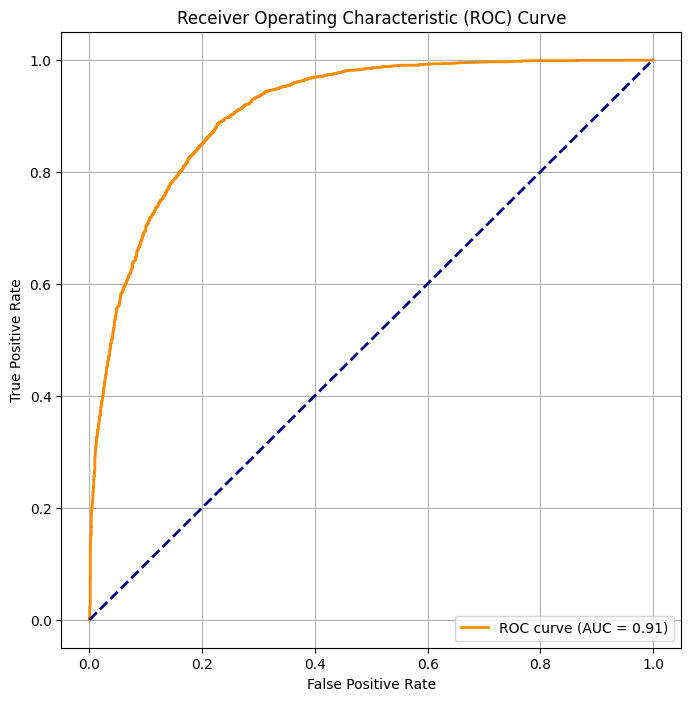

In [ ]:
gModel = globalOptimalModel['model']
with torch.no_grad(): output = gModel(X_test_tensor)
fpr, tpr, thresholds = roc_curve(y_test_tensor.detach().numpy(), output.detach().numpy().flatten(), pos_label=1)
rocAUC = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(rocAUC))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
gLr = globalOptimalModel['hyperparameters']['lr']
gEpochs = globalOptimalModel['hyperparameters']['epochs']
gBatchSize = globalOptimalModel['hyperparameters']['batchSize']
gLambda = globalOptimalModel['hyperparameters']['lambda']

index = int(np.where(thresholds == globalOptimalThreshold)[0])
FPR = fpr[index]
TPR = tpr[index]

print(f'Global Optimal Model Hyperparameters: lr={gLr}, epochs={gEpochs}, batchSize={gBatchSize}, lamda={gLambda}')
print(f'Global Optimal TPR: {TPR}, Global Optimal FPR: {FPR}, Global Optimal Threshold: {globalOptimalThreshold}')
print(f'Global Optimal Acc: {globalOptimalAcc}, Global Optimal Loss: {globalOptimalLoss}')

Global Optimal Model Hyperparameters: lr=0.5, epochs=250, batchSize=1024, lamda=0
Global Optimal TPR: 0.8856067187952505, Global Optimal FPR: 0.22779700115340254, Global Optimal Threshold: 0.4365256130695343
Global Optimal Acc: 0.8289264557144922, Global Optimal Loss: 0.4513971745967865


### Reproducability Test & Visualization

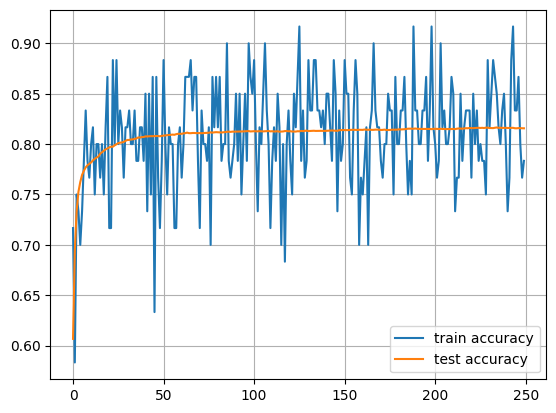

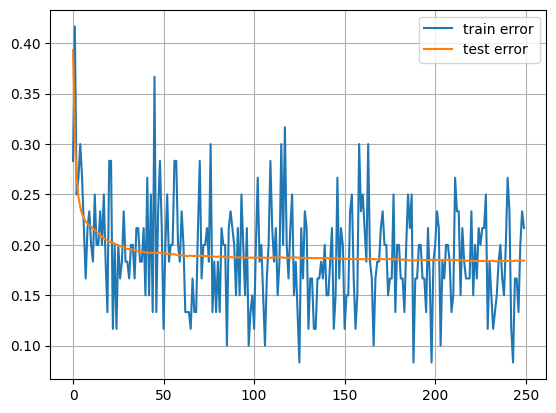

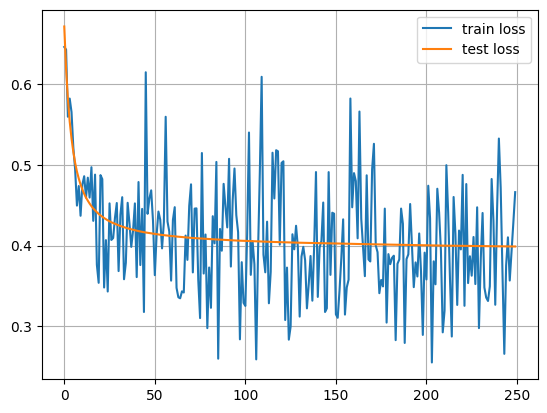

Train Accuracy: 0.7833333333333333, Train Error: 0.21666666666666665, Train Loss: 0.46604787309964496
Test Accuracy: 0.8156480277416559, Test Error: 0.18435197225834418, Test Loss: 0.3987886309623718


In [ ]:
lr = globalOptimalModel['hyperparameters']['lr']
epochs = globalOptimalModel['hyperparameters']['epochs']
batchSize = globalOptimalModel['hyperparameters']['batchSize']
lambda_ = globalOptimalModel['hyperparameters']['lambda']

num_features = len(X_train_df.columns)
model = LogisticRegression(num_features, l2=lambda_)
lossFn = nn.BCELoss()

trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModelKFold(
    model,
    epochs,
    lossFn,
    X_data,
    y_data,
    batchSize=batchSize,
    k=3,
)

model.eval()

plt.plot(trainAcc, label='train accuracy')
plt.plot(testAcc, label='test accuracy')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainErr, label='train error')
plt.plot(testErr, label='test error')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainLoss, label='train loss')
plt.plot(testLoss, label='test loss')
plt.grid(True)
plt.legend()

plt.show()


print(f'Train Accuracy: {trainAcc[-1]}, Train Error: {trainErr[-1]}, Train Loss: {trainLoss[-1]}')
print(f'Test Accuracy: {testAcc[-1]}, Test Error: {testErr[-1]}, Test Loss: {testLoss[-1]}')

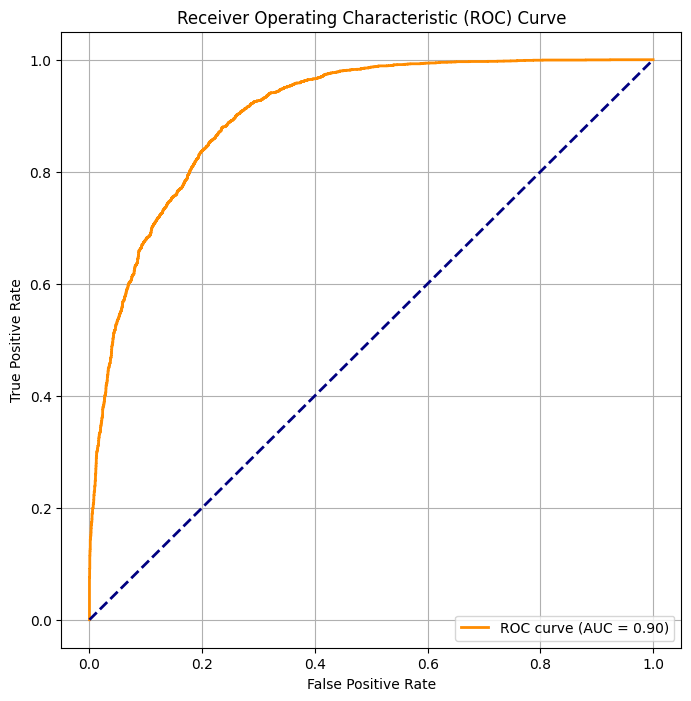

In [ ]:
with torch.no_grad(): output = model(X_test_tensor)
fpr, tpr, thresholds = roc_curve(y_test_tensor.detach().numpy(), output.detach().numpy().flatten(), pos_label=1)
rocAUC = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(rocAUC))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
optimalAcc, optimalThreshold = findOptimalThresholdForModelAcc(
        model,
        X_test_tensor,
        y_test_tensor,
    )

index = int(np.where(thresholds == optimalThreshold)[0])
FPR = fpr[index]
TPR = tpr[index]

print(f'Global Optimal Model Hyperparameters: lr={lr}, epochs={epochs}, batchSize={batchSize}, lamda={lambda_}')
print(f'Global Optimal TPR: {TPR}, Global Optimal FPR: {FPR}, Global Optimal Threshold: {optimalThreshold}')
print(f'Global Optimal Acc: {optimalAcc}, Global Optimal Loss: {testLoss[-1]}')

Global Optimal Model Hyperparameters: lr=0.5, epochs=250, batchSize=1024, lamda=0
Global Optimal TPR: 0.878945844193455, Global Optimal FPR: 0.23500576701268744, Global Optimal Threshold: 0.44527024030685425
Global Optimal Acc: 0.8217020661754082, Global Optimal Loss: 0.3987886309623718


## Time Complexity Analysis

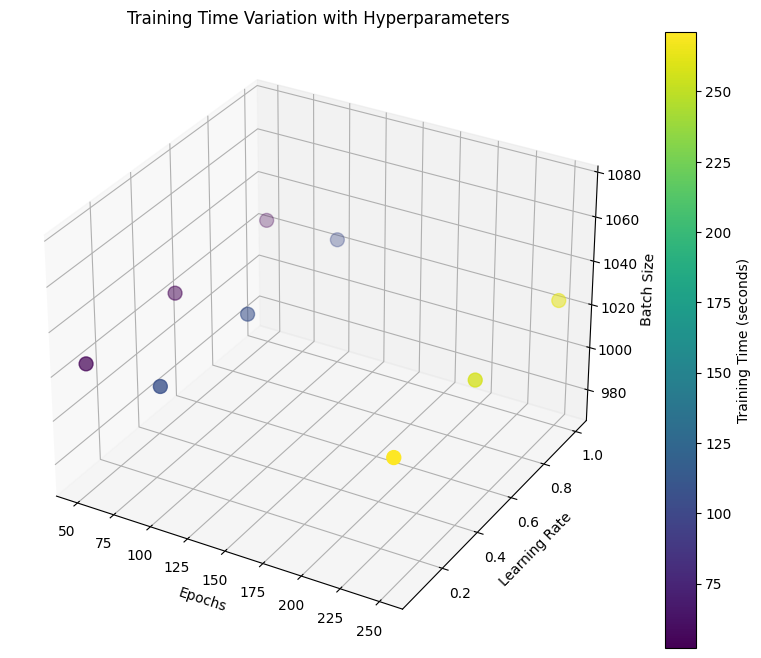

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

lambdaValue = 0.001
filteredModels = [modelInfo for modelInfo in trainedModels if modelInfo['hyperparameters']['lambda'] == lambdaValue]

epochsList = [modelInfo['hyperparameters']['epochs'] for modelInfo in filteredModels]
learningRates = [modelInfo['hyperparameters']['lr'] for modelInfo in filteredModels]
batchSizes = [modelInfo['hyperparameters']['batchSize'] for modelInfo in filteredModels]
trainingTimes = [modelInfo['trainingTime'] for modelInfo in filteredModels]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(epochsList, learningRates, batchSizes, c=trainingTimes, cmap='viridis', marker='o', s=100)
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Batch Size')
ax.set_title('Training Time Variation with Hyperparameters')
cbar = plt.colorbar(sc)
cbar.set_label('Training Time (seconds)')

plt.show()
